In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from ml_utils import graph
import collections
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

out_dir = '../../papi_output/'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


/home/maciej/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[2:55]].min()

In [3]:
def best_neigh(x, y, df, pca_range, neigh_range):
    best = -inf
    best_n = (None, None)
    best_clf = (None, None)

    for n_comp in pca_range:
        for n_neigh in neigh_range:
            pca = PCA(n_components=n_comp)
            pca.fit(x)
            x2 = pca.transform(x)
            
            neigh = KNeighborsRegressor(n_neighbors=n_neigh, weights='distance')
            neigh.fit(x2, y)
            
            groups = list(df.index.get_level_values(0))
            
            cv=GroupKFold(n_splits=3).split(x2, y, groups)
            score = cross_val_score(neigh, x2, y, cv=cv).mean()
            print(n_comp, '\t', n_neigh, '\t', round(score, 2))
            
            if score > best:
                best = score
                best_n = (n_comp, n_neigh)
                best_clf = (pca, neigh)
                
    print('--------------')
    print('PCA:\t', best_n[0])
    print('kNN:\t', best_n[1])
    print('Score:\t', best)
    return best_clf, x2

In [4]:
def load_data(files, scaler=None):
    paths = [out_dir + p for p in files]

    dfs = [pd.read_csv(path, error_bad_lines=False) for path in paths]
    df = pd.concat(dfs)
    df = aggregate(df)

    df = df.loc[df['time'] > 0]

    #for col in df.columns[:52]:
    #    df[col] = df[col].apply(lambda q: np.log(q) if q>0 else 0)

    cols = sorted(list(df.columns.values))
    df = df[cols]

    x = df.drop(['time'],axis=1).as_matrix()
    y = df['time'].as_matrix()
    
    if scaler is None:
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
    else:
        x = scaler.transform(x)

    print(df.shape)
    
    return x, y, df, scaler

In [5]:
x, y, df, scaler = load_data(['o17l.csv'])

(20038, 53)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/maciej/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
(pca, neigh), x2 = best_neigh(x, y, df, range(2, 15, 3), range(6, 20, 4))
clf = neigh

2 	 6 	 0.97
2 	 10 	 0.97
2 	 14 	 0.97
2 	 18 	 0.97
5 	 6 	 0.97
5 	 10 	 0.97
5 	 14 	 0.97
5 	 18 	 0.97
8 	 6 	 0.98
8 	 10 	 0.98
8 	 14 	 0.98
8 	 18 	 0.98
11 	 6 	 0.98
11 	 10 	 0.98
11 	 14 	 0.98
11 	 18 	 0.97
14 	 6 	 0.98
14 	 10 	 0.98
14 	 14 	 0.97
14 	 18 	 0.97
--------------
PCA:	 8
kNN:	 10
Score:	 0.9779290894560159


In [7]:
pca = PCA(n_components=2)
pca.fit(x)
x2 = pca.transform(x)
pca.explained_variance_ratio_.sum()

0.6023779307663318

In [8]:
svr = SVR(kernel='poly', C=1, epsilon=.1)
svr.fit(x2, y)
clf = svr

In [64]:
neigh = KNeighborsRegressor(n_neighbors=10, weights='distance')
neigh.fit(x2, y) 
clf = neigh

In [14]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x2, y)
clf = regr

In [ ]:
groups = list(df.index.get_level_values(0))
n_groups = int(len(set(groups)) / 3)

cv=GroupKFold(n_splits=3).split(x2, y, groups)
cvres = list(cv)
group_names = [groups[q[1][0]] for q in cvres]

scores = cross_val_score(clf, x2, y, cv=cvres)

print('\n'.join([str(round(s, 2))+'\t'+g for g, s in zip(group_names, scores)]))
scores.mean()

In [68]:
x_test, y_test, _, _ = load_data(['o4p.csv'], scaler)
lim = 1000
x_test = x_test[:lim]
y_test = y_test[:lim]

x_test2 = pca.transform(x_test)
pred = clf.predict(x_test2)

for q in x_test2[:10]:
    print('%.2f' % q[0], '%.2f' % q[1])

print()
for p, r in zip(pred, y_test):
    print('%.2f' % p, '\t', '%.2f' % r)

print(r2_score(pred, y_test))

(280, 53)
-0.80 -0.39
0.29 -0.29
2.58 0.06
7.79 0.85
15.04 1.95
21.76 2.33
40.21 5.23
59.21 7.56
83.65 10.52
103.84 13.33

319.18 	 98.38
577.77 	 294.13
1314.18 	 684.67
2029.94 	 1508.58
3479.13 	 2651.56
4666.42 	 4387.39
8538.70 	 7511.51
8888.32 	 11826.19
8785.22 	 17547.48
8736.98 	 21299.87
402.05 	 149.10
910.64 	 433.11
1359.89 	 1131.45
2966.86 	 2389.24
5138.89 	 4221.15
7008.06 	 7078.96
8931.47 	 11422.00
8759.47 	 17944.25
8713.67 	 26609.77
8697.97 	 36486.93
538.30 	 266.14
1322.45 	 762.10
2129.10 	 1704.90
4652.52 	 3301.10
7801.20 	 5643.92
8862.42 	 8953.19
8777.74 	 13134.76
8720.17 	 18638.17
8700.22 	 25278.74
8690.64 	 33845.44
6.33 	 4.37
25.30 	 8.97
18.75 	 14.15
55.18 	 21.64
61.74 	 29.93
116.51 	 40.38
155.75 	 52.28
120.93 	 66.20
251.29 	 82.26
176.31 	 94.86
7.73 	 4.90
13.23 	 9.46
21.12 	 15.87
61.67 	 24.04
87.63 	 33.98
87.26 	 45.29
80.61 	 59.56
136.68 	 74.19
195.60 	 91.40
263.32 	 109.29
446.91 	 679.72
618.42 	 1988.18
892.69 	 4508.32
1129.6

/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/maciej/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


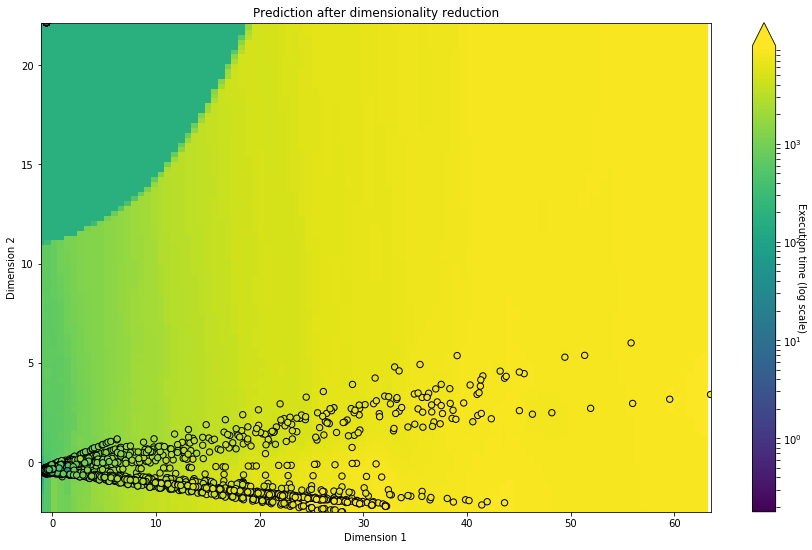

In [66]:
graph(clf, x2, y)

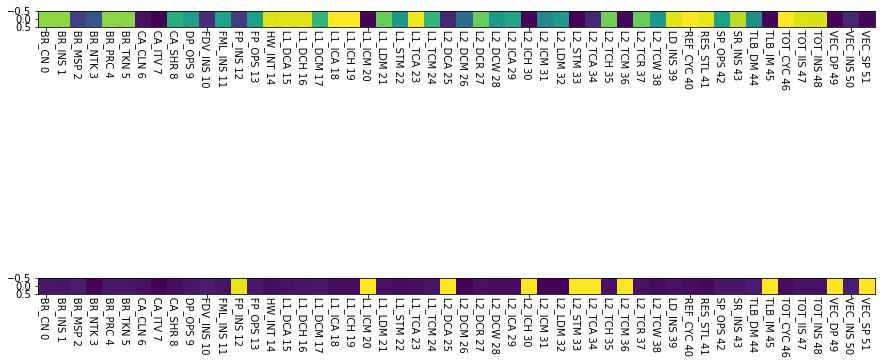

In [183]:
# just to visualize which of 52 PAPI output events are most significant (marked in yellow)

lab = df.columns[:52]

fig, axs = plt.subplots(nrows=pca.n_components)
for i, ax in enumerate(axs): 
    for j, txt in enumerate(lab):
        ax.annotate('      '+txt[5:]+' '+str(j), (j-.5, 0), rotation=270)
    pcas = [abs(q) for q in pca.components_[i:i+1]]
    ax.imshow(pcas)
    ax.set_xticklabels([])
plt.show()

In [29]:
def graph_clusters(pca, x2):
    if pca.n_components != 2:
        print('PCA must be 2D')
        
    db = DBSCAN(eps=0.3, min_samples=10)
    groups = list(df.index.get_level_values(0))
    labels = db.fit_predict(x2)
    
    a = np.array([[l, g] for l, g in zip(labels, groups)])
    algs = unique(a[:,1])
    clusters = unique(a[:,0])
    clusters_algs = array( [ list(a[a[:,1]==i,0]) for i in algs] )
    
    print(len(algs))
    
    #for ca, alg in zip(clusters_algs, algs):
    #    q = [collections.Counter(ca)[str(k)] for k in clusters]
    #    print('kernel', alg.split('_')[-1], '\t', '\t'.join([str(qq) for qq in q]), '\t| ', max(q)/sum(q))
    
    fig, ax = plt.subplots()
    
    plt.title('Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # scatter
    ax.scatter(x2[:,0], x2[:,1], c=labels, cmap='tab10', s=60)

701


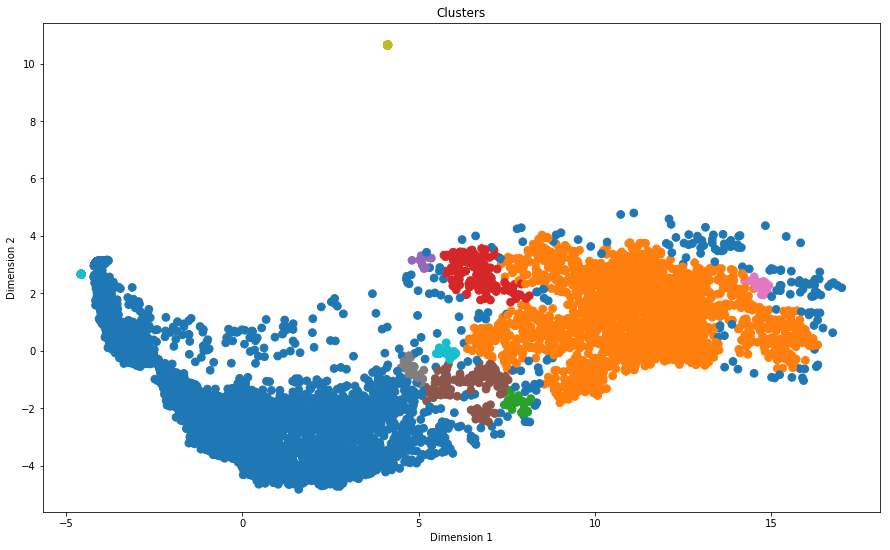

In [84]:
graph_clusters(pca, x2)

In [194]:
x_test = [[1867580,203,1882177,0,1879529,1882177,0,0,0,31524,43,5812530,0,15498,1866679,43,30130476,30059500,0,0,30130476,1089685694,1080673302,90183070,450239457,89948029,30103193,0,301954182,580582800,651075781,652943361,5812530,5812530,0,576598007,240,576598210,240,3939329,1229541571,5821506,5812770,0,30031901,0,90183070,90183070,90183070,0,0,579640051]]
y_test = [555]

x_test = scaler.transform(x_test)
x_test2 = pca.transform(x_test)
print(x_test2, y_test)

print(list(zip(clf.predict(x_test2), y_test)))

[[ -212492.74669674 42644584.28506494]] [555]
[(1196.4867000000002, 555)]


/home/maciej/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/maciej/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


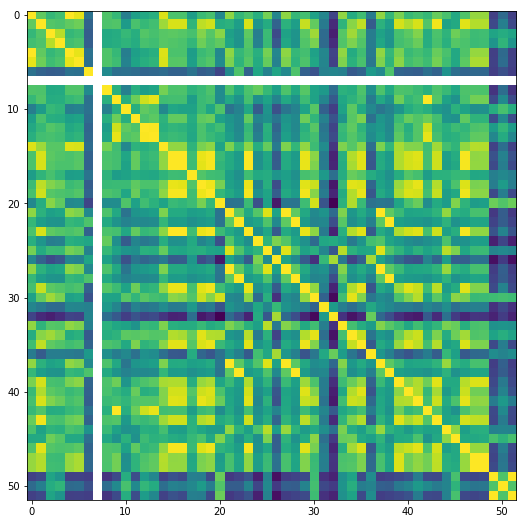

In [109]:
corr = np.corrcoef(x.T)
plt.imshow(corr)

In [21]:
clf.predict([[3, 4], [-2, -1]])

array([1832.18600948,  233.74885286])